# Learning to Navigate with Gaussian Processes

Imagine you've landed a robot on a remote planet and are now trying to explore that planet to find potential life forms. The spaceship which landed your robot is still orbiting the planet and taking measurements of the elevation. Our goal will be to plan an energy-efficient path on the surface based on those measurements.

<p style="text-align:center;">
<img src='img/learning_to_plan_illustration.jpg' width="800">
</p>

# Setup

**Task:**  If you haven't already, install the required packages in a fresh Python environment via the following command:

```bash
cd 2023_tutorials
pip install -r requirements.txt
```

If you can execute the next cell with import statements successfully, everything should work as intended.

In [1]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker
%config InlineBackend.figure_formats = ['svg']
%matplotlib widget

import tueplots
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())

cmap_norm = mpl.colors.TwoSlopeNorm(vmin=-1.25, vcenter=0.0, vmax=1.25)

# Scientific computing
import numpy as np
import scipy
import probnum
from probnum import backend
import itergp
import pykeops
pykeops.set_verbose(False)

# Tutorial-specific code
from path_planning.landscapes import generate_landscape
from path_planning.dataset import Dataset
from path_planning.cost_functions import energy_cost
from path_planning.plotting import plot_path_cost

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


# Simulation

Before we blast off into space, we'll start with our robot still on the ground. We'll first explore a simulated landscape to get an idea of the kind of altitude data we'll obtain based off of which we'll decide how to navigate.

**Task:** Simulate a few landscapes and corresponding datasets and get a feel for the data.

In [2]:
# Simulated landscape
seed = 999
simulated_landscape_fn = generate_landscape(seed=seed)

# Satellite measurements
num_train_data = 100000
simulated_train_data = Dataset(simulated_landscape_fn, num=num_train_data, seed=seed)

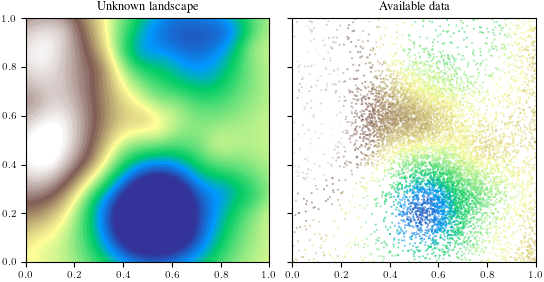

In [3]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot simulated landscape
    x0s = np.linspace(0, 1.0, 100)
    x1s = np.linspace(0, 1.0, 100)
    X0, X1 = np.meshgrid(x0s, x1s)
    X_test = np.vstack([X0.ravel(), X1.ravel()]).T
    F = simulated_landscape_fn(X_test).reshape(X0.shape)
    axs[0].contour(X0, X1, F, levels=50, cmap="terrain", norm=cmap_norm)
    axs[0].imshow(
        F,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm
    )

    # Simulated landscape data
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    axs[1].scatter(simulated_train_data.X[0:n_subset, 0], simulated_train_data.X[0:n_subset, 1], c=simulated_train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Unknown landscape")
    axs[1].set(title="Available data")
    plt.show()

# Path Planning in Simulation

Now to explore the remote planet we want to move our robot from a starting point to a certain location. However, we only have limited energy resources available and need to find a path that is efficient to drive along.

In [4]:
startpoint = np.asarray([0.1, 0.1])
endpoint = np.asarray([0.9, 0.9])

**Task:** Based on the simulated landscape, plan a few paths in the widget below and measure their energy cost. Try to find a path in the simulated landscape that is energy-efficient. What factors likely determine the energy cost?

*Hint: You can plan a path by clicking on either "Path 1" or "Path 2" in the legend. Then add points by left-clicking and remove points by right-clicking near the point to be removed. The starting point is automatically part of the path.*

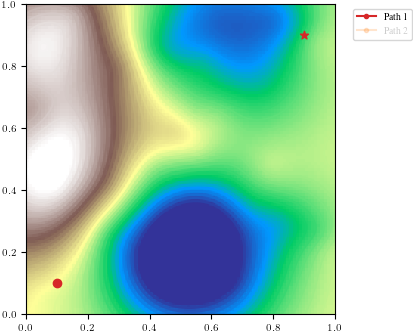

In [5]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()

    # # Landscape data
    # n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    # ax.scatter(simulated_train_data.X[0:n_subset, 0], simulated_train_data.X[0:n_subset, 1], c=simulated_train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Simulated landscape
    ax.contour(X0, X1, F, levels=50, cmap="terrain", norm=cmap_norm)
    ax.imshow(
        F, origin="lower", extent=(0.0, 1.0, 0.0, 1.0), cmap="terrain", norm=cmap_norm
    )

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(
        ax, path_list, markers=[".", "."], colors=["C3", "C1"], linestyle="-"
    )
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})

    # Plot settings
    ax.set_aspect("equal")
    # ax.set_facecolor("black")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


In [6]:
# Get paths from widget
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

print(path1)

[[0.1 0.1]]


In [7]:
# Measure energy cost of moving on simulated landscape
energy_cost1 = energy_cost(path1, landscape=simulated_landscape_fn)
energy_cost2 = energy_cost(path2, landscape=simulated_landscape_fn)

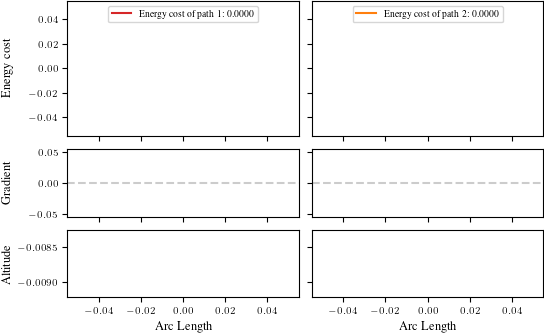

In [8]:
# Plot energy cost along path
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)

# Path Planning in Practice

Now in practice, we of course do not know the actual landscape and therefore cannot measure the energy cost of a planned path until we have actually driven to the target location. Therefore, we have *only one shot* at planning an efficient path based on the measurement data from our satellite. 

In [9]:
# True landscape unknown to our robot
landscape_fn = generate_landscape(seed=17)

# Satellite measurements
num_train_data = 100000
train_data = Dataset(landscape_fn, num=num_train_data)
train_data.X.shape

(100000, 2)

Path planning solely from data can be considerably harder.

**Questions:** What potential issues make the planning problem hard if we only have measurements from our satellite available? How can we use the altitude data to still plan an efficient path?

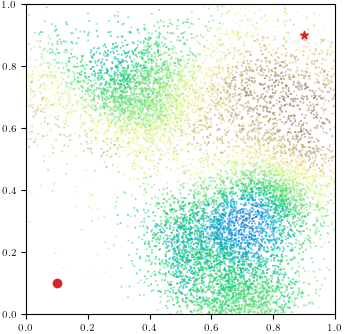

In [10]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()

    # Landscape data
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    ax.scatter(train_data.X[0:n_subset, 0], train_data.X[0:n_subset, 1], c=train_data.y[0:n_subset], cmap="terrain", s=0.1, norm=cmap_norm)

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)
    
    # Plot settings
    ax.set_aspect("equal")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


# Learning the Landscape

We'll try to learn the surface of the remote planet from the data and then plan a path based on the inferred landscape. Since we want to use energy conservatively, we need a model which can quantify uncertainty arising from missing data to avoid unknown hills or valleys and is robust to noise in the data to avoid taking costly detours. We'll use a Gaussian process for this purpose.

## Gaussian Processes



### Prior Information

From simulation and previous missions, we have a rough idea of what geological structures on the remote planet look like and how the landscape varies. We can encode this knowledge in the prior by selecting a specific kernel. 

In [11]:
from probnum import randvars, linops
from probnum.randprocs import mean_fns
from itergp.kernels import Matern
from itergp import GaussianProcess, methods

input_shape = (2,)

# GP prior
mean_fn = mean_fns.Zero(input_shape)
kernel = Matern(input_shape, lengthscale=0.1, nu=3.5)

gp = GaussianProcess(mean_fn, kernel)

**Task:** Visualize the kernel matrix. What structure can you observe? How do you explain this structure?

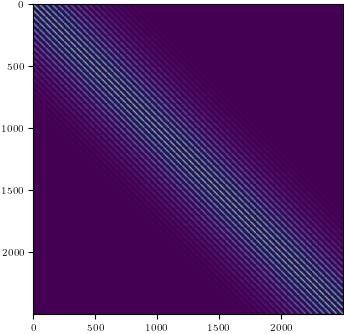

In [12]:
# Generate some test data on a 2D grid
x0s = np.linspace(0, 1.0, 50)
x1s = np.linspace(0, 1.0, 50)
X0, X1 = np.meshgrid(x0s, x1s)
X_test = np.vstack([X0.ravel(), X1.ravel()]).T

# Plot the kernel matrix
plt.close()
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()
    ax.imshow(kernel.matrix(X_test))
    plt.show()

**Task:** To get a feel for the assumptions encoded in our prior let's visualize it and some corresponding (slices of) draws.

In [13]:
# Draw samples from the Gaussian process prior
rng_state = backend.random.rng_state(0)
samples_2D = gp.sample(rng_state, X_test, sample_shape=(5,))


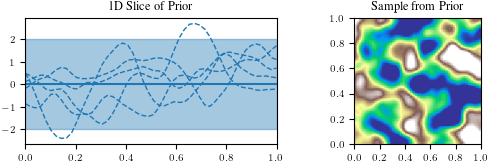

In [14]:
# Prior visualization
plt.close()
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0, ncols=2)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)

    # 1D slice with samples
    X_test_slice = np.vstack([x0s, 0.5 * np.ones_like(x0s)]).T
    gp_mean = gp.mean(X_test_slice)
    axs[0].plot(X_test_slice, gp_mean, color="C0")
    axs[0].fill_between(
        x0s,
        y1=gp_mean + 2 * gp.std(X_test_slice),
        y2=gp_mean - 2 * gp.std(X_test_slice),
        color="C0",
        alpha=0.4,
    )

    axs[0].set(title="1D Slice of Prior")
    axs[0].plot(
        x0s,
        samples_2D.reshape(-1, *X0.shape)[:, :, 0].T,
        color="C0",
        linestyle="--",
        lw=1.0,
    )

    # Sample of prior
    axs[1].imshow(
        samples_2D.reshape(-1, *X0.shape)[0, :, :],
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )
    axs[1].set(title="Sample from Prior")

    # Plot settings
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)

    plt.show()


### Likelihood
Let's assume we also have a rough idea of what the noise in the measurement data is that our satellite collects.

In [15]:
# Likelihood
sigma_sq = 0.1
noise = randvars.Normal(
    mean=np.zeros_like(train_data.y),
    cov=linops.Scaling(sigma_sq, shape=(num_train_data, num_train_data)),
)

### Inference

To be able to predict the landscape of the remote planet and to ultimately plan an energy-efficient path, we need to update our prior with the information contained in the satellite measurements. The Gaussian process posterior $f \sim \mathcal{GP}(\mu_{*}, k_{*})$ is fully defined by its mean and covariance function given by

$$
\begin{align*}
    \mu_*(x) &= \mu_0(x) + k(x, X)\hat{K}^{-1}(y - \mu_0(X))\\
    k_*(x, x') &= k(x, x') - k(x, X)\hat{K}^{-1}k(X, x')
\end{align*}
$$

**Numerical Implementation**:

The textbook way to implement the mathematical operations necessary to evaluate the Gaussian process posterior is to solve the linear systems involving the symmetric positive definite kernel Gram matrix $\hat{K} = k(X, X) + \sigma^2I$ via a Cholesky factorization. This means we compute a matrix decomposition $$\operatorname{chol}(K + \sigma^2I) = LL^\top,$$ where $L$ is a lower triangular matrix and then solve $L^{-1}(L^{-\top}b)$, where the right hand side is either $b=y - \mu_0(X)$ or $b=k(X, x')$. The linear solves with $L$ are efficient since $L$ is triangular.

**Task:** Implement the Gaussian process posterior using a Cholesky decomposition as [implemented in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cho_solve.html).

In [16]:
from scipy.linalg import cho_factor, cho_solve

# Implement Gaussian process via Cholesky decomposition

def condition_on_data(gp_prior, X_test, X_train, y_train):
    # Kernel Gram matrix
    gram_matrix = gp_prior.cov.matrix(X_train) + sigma_sq * np.eye(X_train.shape[0])

    # Cholesky factorization
    L, is_lower = cho_factor(gram_matrix, lower=True)

    # Kernel evaluated at training data
    KXx = gp_prior.cov.matrix(X_train, X_test)

    # Posterior mean
    post_mean = gp_prior.mean(X_test) + KXx.T @ cho_solve(
        (L, is_lower), y_train - gp_prior.mean(X_train)
    )

    # Posterior covariance
    post_cov = (
        gp_prior.cov.matrix(X_test)
        - KXx.T @ cho_solve((L, is_lower), KXx)
        # + sigma_sq * np.eye(X_test.shape[0])
    )

    return post_mean, post_cov


**Task:** Test your implementation on a small training and test dataset.

In [17]:
# Training data
X_train = train_data.X[0:100]
y_train = train_data.y[0:100]

# Test data
x0s = np.linspace(0, 1.0, 50)
x1s = np.linspace(0, 1.0, 50)
X0, X1 = np.meshgrid(x0s, x1s)
X_test = np.vstack([X0.ravel(), X1.ravel()]).T

# Compute GP posterior
post_mean, post_cov = condition_on_data(gp, X_test, X_train, y_train)

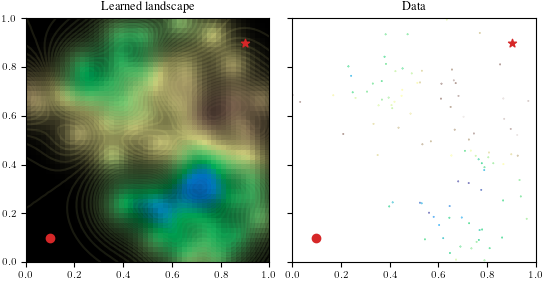

In [18]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot inferred landscape
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        uncertainty = np.sqrt(np.diag(post_cov))
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        uncertainty_overlay = 1.0 - uncertainty.reshape(X0.shape) / np.max(uncertainty)
        axs[0].imshow(black_background)

    axs[0].contour(
        X0,
        X1,
        post_mean.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        post_mean.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Data
    axs[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="terrain", s=0.1)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Learned landscape")
    axs[1].set(title="Data")
    plt.show()


## Scaling to Large Datasets

Using only a hundred datapoints of the dataset we have available is wasteful. We have a lot more data available. Can we use more of the training data to plan a better path?

**Task:** Try to condition your implementation of a GP on 50k datapoints. What happens and why?

In [19]:
# Large training dataset
X_train = train_data.X[0:50000]
y_train = train_data.y[0:50000]

post_mean, post_var = condition_on_data(gp, X_test, X_train, y_train)


MemoryError: Unable to allocate 37.3 GiB for an array with shape (50000, 50000, 2) and data type float64

### Matrix-free Kernel Matrices

Trying to form the kernel matrix $K=k(X, X) \in \mathbb{R}^{n \times n}$ in memory to perform the Cholesky decomposition with 50k datapoints quickly becomes prohibitive. 
But, while kernel matrices are generally dense not sparse, they are nonetheless highly structured as we saw earlier. 

<p style="text-align:center;">
<img src='img/keops.png' width="800">
</p>

**Question:** Can we exploit this structure induced by our probabilistic model for more efficient computation?

Absolutely, by representing the kernel matrices in a *matrix-free* fashion, meaning we only store the dataset and the mathematical operation defining the kernel. We can then multiply with this matrix by (in parallel) computing row-wise matrix-vector products. This allows to multiply with the kernel matrix without forming it in memory. Here, we use the library [KeOps](https://www.kernel-operations.io/keops/index.html) to do this. This kind of parallel computation of dense matrix-vector products is the operation that GPUs are purpose-built for.

**Task:** Create a kernel "linear operator" via `kernel.linop` instead of `kernel.matrix` which gives a matrix-free representation of the kernel matrix and multiply with a vector with 50k entries. How long does formation of the matrix-free representation take and how long does the matrix-vector product take on your machine?

In [21]:
# Matrix-free representation of kernel matrix as "linear operator"
K = kernel.linop(train_data.X[0:50000])

In [22]:
# Large-scale matrix-vector product still possible
(K @ np.ones(50000)).shape

(50000,)

In [ ]:
# Scalable kernel with GPU compatibility
# TODO:
import torch
from gpytorch.kernels.keops import MaternKernel

device = torch.device("cuda")
X_gpu = torch.as_tensor(train_data.X, device=device)
kernel.to(device=device)

k = Matern(nu=3.5, lengthscale=0.1)

In [ ]:
# Large-scale matrix-vector product with kernel matrix on GPU
k(X_gpu, X_gpu) @ torch.ones(X_gpu.shape[0])

## Computation-Aware GP Inference

Accurate images on satellite around Mars, but communication with earth is slow and hardware is limited on satellite / robot. Need fast inference with little computation time. Can accept uncertainty, if path planning still is possible.

% TODO: explain matrix-vector based GP inference, reference ideas from John's talk

In [ ]:
# Iteratively computed combined GP posterior
gp_post = gp.condition_on_data(
    # train_data.X, train_data.y, noise, approx_method=methods.CG(maxiter=5)
    train_data.X, train_data.y, noise, approx_method=methods.Cholesky(maxrank=100)
)


In [ ]:
# Marginal GP prediction on a million datapoints
x0s = np.linspace(0, 1.0, 1000)
x1s = np.linspace(0, 1.0, 1000)
X0, X1 = np.meshgrid(x0s, x1s)
X_pred = np.vstack([X0.ravel(), X1.ravel()]).T
y_pred = gp_post.mean(X_pred)
uncertainty = gp_post.std(X_pred)


In [ ]:
X_pred.shape

(1000000, 2)

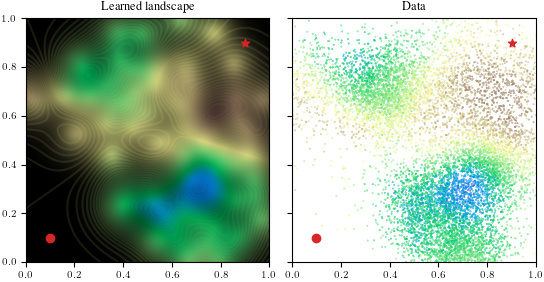

In [ ]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot inferred landscape
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        uncertainty_overlay = 1.0 - uncertainty.reshape(X0.shape) / np.max(uncertainty)
        axs[0].imshow(black_background)

    axs[0].contour(
        X0,
        X1,
        y_pred.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        y_pred.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Data
    n_subset = np.minimum(10000, num_train_data)  # Subset training data for plot
    axs[1].scatter(
        train_data.X[0:n_subset, 0],
        train_data.X[0:n_subset, 1],
        c=train_data.y[0:n_subset],
        cmap="terrain",
        s=0.1,
        norm=cmap_norm,
    )

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Learned landscape")
    axs[1].set(title="Data")
    plt.show()


In [ ]:
# TODO: Talk about uncertainty tradeoff

### Design Your Own Approximation Method

In [ ]:
# TODO: imshow part of kernel matrix and plot sparse vector

In [ ]:
from typing import Optional
from probnum.backend.random import RNGState

import probnum
from probnum import backend
from probnum.linalg.solvers import ProbabilisticLinearSolver, information_ops, policies

from itergp.methods import belief_updates, stopping_criteria


class MyPolicy(policies.LinearSolverPolicy):
    def __init__(self) -> None:
        super().__init__()

    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState],
    ) -> backend.Array:
        """Return an action for a given solver state.

        Parameters
        ----------
        solver_state
            Current state of the linear solver.
        rng
            Random number generator state.

        Returns
        -------
        action
            Next action to take. Must have shape=(n,).
        """
        rng = np.random.default_rng(rng)

        # Random Gaussian actions
        # return rng.standard_normal(size=(solver_state.problem.A.shape[1],))

        # CG on subset of data
        action = np.zeros(solver_state.problem.A.shape[1])
        # action[0:2000] = solver_state.residual[0:2000]

        # CG along diagonal strip
        # idcs = np.where(np.abs(train_data.X[:, 0] - train_data.X[:, 1]) < 0.1)[0]
        # action[idcs] = solver_state.residual[idcs]

        # Use only data with altitude similar to (predicted) starting altitude to find level set
        idcs = np.where(np.abs(train_data.y - landscape_fn(startpoint)) < 0.1)[0]
        action[idcs] = solver_state.residual[idcs]

        # Only data with small gradient norm

        # Data with highest uncertainty (over gradients), etc...

        # # Store data between steps
        # if solver_state.step == 0:
        #     solver_state.cache["my_data"] = 3.0
        # else:
        #     action[solver_state.step] = solver_state.cache["my_data"]

        return action


In [ ]:
class MySolver(ProbabilisticLinearSolver):
    def __init__(
        self,
        atol: float = 1e-6,
        rtol: float = 1e-6,
        maxiter: int = None,
    ):
        super().__init__(
            policy=MyPolicy(),
            information_op=information_ops.ProjectedResidualInformationOp(),
            belief_update=belief_updates.ProjectedResidualBeliefUpdate(),
            stopping_criterion=stopping_criteria.MaxIterationsStoppingCriterion(
                maxiter=maxiter,
            )
            | probnum.linalg.solvers.stopping_criteria.ResidualNormStoppingCriterion(
                atol=atol, rtol=rtol
            ),
        )


In [ ]:
# Compute combined posterior 
# (uncertainty from limited data + uncertainty from limited computation)
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=MySolver(maxiter=20)
)


In [ ]:
# Marginal GP prediction
y_pred = gp_post.mean(X_pred)
uncertainty = gp_post.std(X_pred)

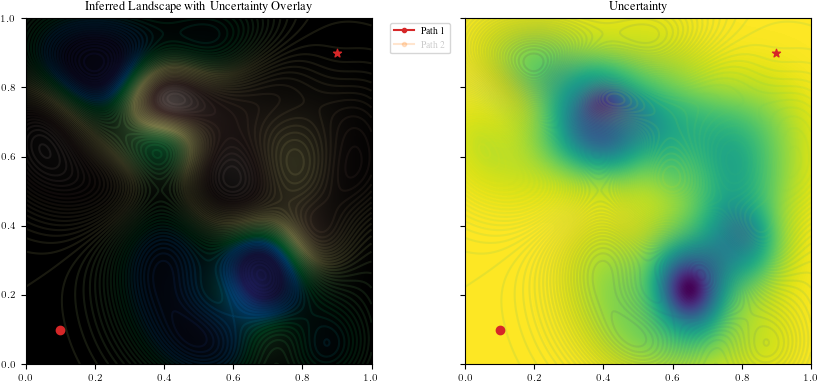

In [ ]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.5)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Evaluate landscape function for plotting
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        axs[0].imshow(black_background)
        uncertainty_overlay = 1.0 - uncertainty.reshape(X.shape) / np.max(uncertainty)

    axs[0].contour(
        X0,
        X1,
        y_pred.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        y_pred.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Uncertainty
    axs[1].contour(X0, X1, y_pred.reshape(X0.shape), levels=50, alpha=0.1)
    axs[1].imshow(
        uncertainty.reshape(X0.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
    )

    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(
        axs[0], path_list, markers=[".", "."], colors=["C3", "C1"], linestyle="-"
    )
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})

    # Plot settings
    axs[0].set_title(
        "Inferred Landscape with Uncertainty Overlay"
        if use_uncertainty_overlay
        else "Inferred Landscape"
    )
    axs[1].set_title("Uncertainty")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)
    plt.show()


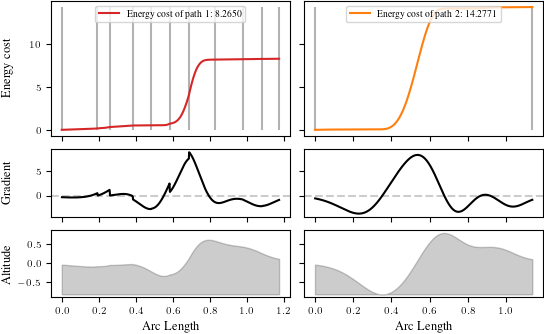

In [ ]:
# Get paths from widget
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

# Predict energy cost of based on GP
energy_cost1 = energy_cost(path1, landscape=gp_post.mean)
energy_cost2 = energy_cost(path2, landscape=gp_post.mean)

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)


In [ ]:
# TODO: Use clicker to let people choose observation points (and their weighing through an array later on)?
# TODO: Plot gradient vector field to choose path?



# Final Results

Let's see how good the path is you've chosen based on the learned landscape. Compare with the people sitting next to you who found the path with the least energy cost!

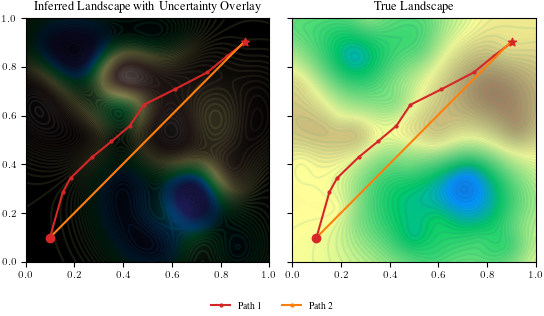

In [ ]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Inferred landscape with uncertainty overlay
    axs[0].imshow(black_background)
    axs[0].contour(
        X0,
        X1,
        y_pred.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        y_pred.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Actual landscape
    y_true = landscape_fn(X_pred)
    axs[1].contour(
        X0, X1, y_true.reshape(X0.shape), levels=50, alpha=0.1, norm=cmap_norm
    )
    axs[1].imshow(
        y_true.reshape(X0.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs[0:2]:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Plot paths
    for ax in axs[0:2]:
        ax.plot(
            path1[:, 0], path1[:, 1], "-o", markersize=2, color="C3", label="Path 1"
        )
        ax.plot(
            path2[:, 0], path2[:, 1], "-o", markersize=2, color="C1", label="Path 2"
        )

    # Plot settings
    axs[0].set_title(
        "Inferred Landscape with Uncertainty Overlay"
        if use_uncertainty_overlay
        else "Inferred Landscape"
    )
    axs[1].set_title("True Landscape")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)

    # Legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles=handles,
        labels=labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.05),
        fancybox=False,
        shadow=False,
        ncol=2,
        frameon=False,
    )

    plt.show()


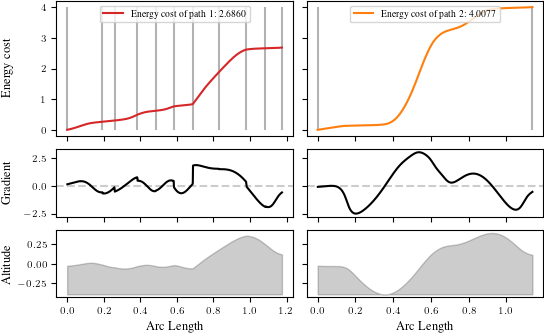

In [ ]:
# Measure energy cost of moving on actual landscape
energy_cost1 = energy_cost(path1, landscape=landscape_fn)
energy_cost2 = energy_cost(path2, landscape=landscape_fn)

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)

# Conclusion

## Takeaways
- GPs are not expensive if we pay attention to the numerics
  - train on >100k datapoints on CPU with small memory
  - predict on >1m datapoints
- GPs allow us to trade off resources for uncertainty exactly and explicitly
- Limited data and limited compute induce uncertainty

## Extensions?
- Automatic path planning with (uncertainty-aware) path planning algorithm (like Dikstra, A*) based on GP
- Predict gradient vector field with GP in closed form
- Actively collect / compute on data based on a driven segment
- belief over energy cost / elevation via GP
- ... student's ideas?

# References

Libraries:
- ProbNum 
- IterGP
- KeOps

Papers:
- Posterior and Computational Uncertainty
- BayesCG
- KeOps
- GPyTorch?